In [1]:
# The C2QA pacakge is currently not published to PyPI. 
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import math

import c2qa
import c2qa.util
import matplotlib.pyplot
import numpy
import qiskit

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

## Displacement Gate Calibration
The following circuit is a way to calibrate the conditional displacement gate. 

In [6]:
def calibration_circuit(dist, num_qumodes = 1, num_qubits_per_mode = 4, animation_segments: int = math.nan):
    qmr = c2qa.QumodeRegister(num_qumodes=num_qumodes, num_qubits_per_mode=num_qubits_per_mode)
    qr = qiskit.QuantumRegister(size=1)
    cr = qiskit.ClassicalRegister(size=1)
    circuit = c2qa.CVCircuit(qmr, qr, cr, animation_segments=animation_segments)

    circuit.initialize([1,0], qr[0])
    circuit.cv_initialize(0, qmr[0])

    circuit.h(qr[0])
    circuit.cv_cnd_d(dist, -dist, qr[0], qmr[0])
    circuit.cv_d(1j * dist, qmr[0])
    circuit.cv_cnd_d(-dist, dist, qr[0], qmr[0])
    circuit.cv_d(-1j * dist, qmr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0], cr[0])

    return circuit

## Simulate one shot to plot Wigner function 
The statevector_simulator produces a state vector output. Then use the state vector to plot the Wigner function using the c2qa.util module.

In [4]:
circuit  = calibration_circuit(numpy.sqrt(numpy.pi) / numpy.sqrt(2))
backend = qiskit.Aer.get_backend("statevector_simulator")
job = qiskit.execute(circuit, backend)
result = job.result()

state = result.get_statevector(circuit)
counts = result.get_counts(circuit)

print("Simulated statevector:")
print(state)
print("Simulated result counts:")
print(counts)

Simulated statevector:
[-7.07106758e-01+7.07106758e-01j  1.00055074e-06+1.00055071e-06j
 -4.79975071e-06+4.79975070e-06j -6.18688729e-06-6.18688729e-06j
 -1.98534206e-05+1.98534206e-05j -7.59057891e-05-7.59057891e-05j
  6.71530123e-05-6.71530123e-05j -4.78493504e-05-4.78493504e-05j
  6.10806392e-05-6.10806392e-05j -5.08042892e-05-5.08042892e-05j
 -1.19064095e-05+1.19064095e-05j -5.96624839e-05-5.96624839e-05j
 -5.30215932e-05+5.30215931e-05j  1.47685345e-05+1.47685345e-05j
  2.22962333e-05-2.22962333e-05j  7.74612547e-05+7.74612547e-05j
  0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  

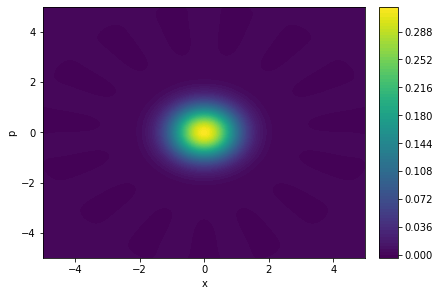

In [5]:
# Plot Fock state Wigner function with QuTiP
c2qa.util.plot_wigner_fock_state(circuit, state)

## Iterate over incremental displacements
Iteratively simulate the calibration cicruit with incremental differences in the displacement and plot probability difference results.

In [14]:
# Run the simulations
backend = qiskit.Aer.get_backend("qasm_simulator")
up = numpy.linspace(numpy.sqrt(2), 2, 20)
down = numpy.linspace(2, numpy.sqrt(2), 20)
steps = []

for _ in range(2):
    steps.extend(up[0:19])
    steps.extend(down[0:19])

x = []
y = []

for i, step in enumerate(steps):
    dist = numpy.sqrt(numpy.pi) / step
    circuit = calibration_circuit(dist)

    job = qiskit.execute(circuit, backend, shots=32)
    result = job.result()

    counts = result.get_counts(circuit)

    x.append(i)
    y.append(counts.get("0", 0) - counts.get("1", 0))

    print(f"{i}: {counts}")

0: {'0': 32}
1: {'0': 32}
2: {'0': 30, '1': 2}
3: {'0': 28, '1': 4}
4: {'0': 21, '1': 11}
5: {'0': 19, '1': 13}
6: {'0': 19, '1': 13}
7: {'0': 18, '1': 14}
8: {'0': 11, '1': 21}
9: {'0': 7, '1': 25}
10: {'0': 9, '1': 23}
11: {'0': 6, '1': 26}
12: {'0': 4, '1': 28}
13: {'0': 2, '1': 30}
14: {'0': 3, '1': 29}
15: {'1': 32}
16: {'0': 1, '1': 31}
17: {'0': 1, '1': 31}
18: {'1': 32}
19: {'1': 32}
20: {'1': 32}
21: {'1': 32}
22: {'1': 32}
23: {'0': 1, '1': 31}
24: {'0': 2, '1': 30}
25: {'0': 2, '1': 30}
26: {'0': 4, '1': 28}
27: {'0': 5, '1': 27}
28: {'0': 8, '1': 24}
29: {'0': 7, '1': 25}
30: {'0': 12, '1': 20}
31: {'0': 16, '1': 16}
32: {'0': 19, '1': 13}
33: {'0': 19, '1': 13}
34: {'0': 28, '1': 4}
35: {'0': 26, '1': 6}
36: {'0': 30, '1': 2}
37: {'0': 32}
38: {'0': 32}
39: {'0': 32}
40: {'0': 28, '1': 4}
41: {'0': 28, '1': 4}
42: {'0': 26, '1': 6}
43: {'0': 17, '1': 15}
44: {'0': 20, '1': 12}
45: {'0': 21, '1': 11}
46: {'0': 13, '1': 19}
47: {'0': 11, '1': 21}
48: {'0': 8, '1': 24}
49: {'

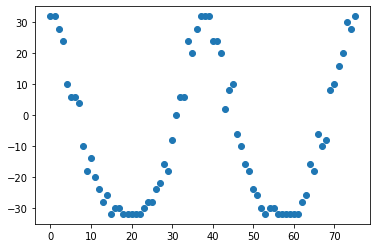

In [15]:
# Plot the results
matplotlib.pyplot.scatter(x, y)
matplotlib.pyplot.show()

## Animate the circuit

In [7]:
circuit  = calibration_circuit(dist=numpy.sqrt(numpy.pi) / numpy.sqrt(2), animation_segments=10)
backend = qiskit.Aer.get_backend("statevector_simulator")
job = qiskit.execute(circuit, backend)
result = job.result()

c2qa.util.animate_wigner_fock_state(circuit, result)

AttributeError: module 'c2qa' has no attribute 'util'